<a href="https://colab.research.google.com/github/ShenChikai/Aritificial-Intelligence/blob/main/Chikai_Shen_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h1> Game playing </h1> </center>

In this homework, we will create chess-playing agent.

More specifically, we will:
1. Implement minimax algorithm.
2. Implement minimax with alpha beta prunning.
3. Apply these algorithms to solve checkmate puzzles in chess.
4. Make two agents play against each other.
5. Play against your own agent yourself.

<center> <h2> Setup </h2> </center>

#### Google colaboratory

Before getting started, get familiar with google colaboratory:
https://colab.research.google.com/notebooks/welcome.ipynb

This is a neat python environment that works in the cloud and does not require you to
set up anything on your personal machine
(it also has some built-in IDE features that make writing code easier).
Moreover, it allows you to copy any existing collaboratory file, alter it and share
with other people. In this homework, we will ask you to copy current colaboraty,
complete all the tasks and share your colaboratory notebook with us so
that we can grade it. We will also use colaboratory for the homework #4 so this
homework will prepare you for it.

#### Python-chess library

In order to avoid implementing the rules of the chess and visualization features we will use
a ```python-chess``` library. It is already a part of any google colaboratory environment so you do not
need to do any additional steps. We recommend you to go through a small tutorial on ```python-chess``` library:
https://jupyter.brynmawr.edu/services/public/dblank/CS371%20Cognitive%20Science/2016-Fall/Programming%20a%20Chess%20Player.ipynb

#### Submission

Before you start working on this homework do the following steps:

1. Press __File > Save a copy in Drive...__ tab. This will allow you to have your own copy and change it.
2. Follow all the steps in this collaboratory file and write/change/uncomment code as necessary.
3. Do not forget to occasionally press __File > Save__ tab to save your progress.
4. After all the changes are done and progress is saved press __Share__ button (top right corner of the page), press __get shareable link__ and make sure you have the option __Anyone with the link can view__ selected.
5. Paste the link into your submission pdf file so that we can view it and grade.

<center> <h2> Problem statement </h2> </center>

In this work we will try to find the best move given current position of figures on the board, 
assuming that we play against a perfect player.

(It is useful to know the rules of chess before you start:
https://en.wikipedia.org/wiki/Rules_of_chess)

Before we start to play the full game of chess, we will have a look at checkmate puzzles (Read more about it here:
https://en.wikipedia.org/wiki/Chess_problem#Types_of_problems).

The task is basically to find a combination of moves that will lead to checkmate against any defence.
This is a good way to check our agent before letting it play the full game. You will also have to
provide solutions to our puzzles to get credit for the asignment.

You can also try solving some puzzles on your own to better understand the problem:
https://www.chess.com/forum/view/more-puzzles/300-checkmate-puzzles-puzzles-1---50

Let us load one of the puzzles and visualize the initial board position:

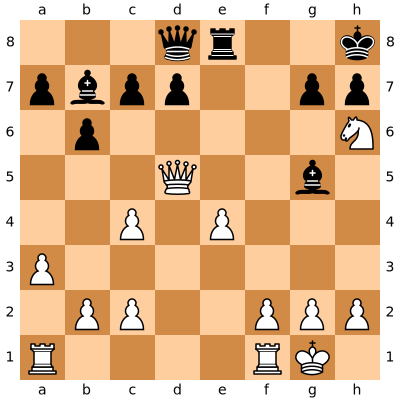

In [2]:
import chess

board = chess.Board(fen='3qr2k/pbpp2pp/1p5N/3Q2b1/2P1P3/P7/1PP2PPP/R4RK1 w - - 0 1')

# Display the board
board

<center> <h2> Evaluation function </h2> </center>

If you remember from the lecture, minimax traverses the game tree until it reaches
the leaf node that represents terminal state of the game (which in chess
usually means checkmate or draw). After reaching the terminal state, the
utility function is applied and the score value is returned. For example, $1$ white wins,
$0$ for draw, $-1$ black wins. Unfortunately, given the branching factor of the game, evaluating all
possible moves is not currently possible.

To get around this, we decide to limit the depth of our game tree to a certain number
and evaluate the leaf nodes using an evaluation function (see lecture slides) that estimates the
desirability of a position. Since we limit the game tree depth, some leaf nodes have a certain outcome (like checkmate or draw) while others do not. When we do not have an exact outcome we use the fuction to estimate
the outcome of the position by counting the number of pawns, rooks, queens etc. while also assigning different
weight to figures based on their importance.

Below you can see an implementation of the evaluation function and evaluate our board:

In [3]:

def evaluate_board(board):
    
    # Pawn -- 10 points
    # Knight -- 30 points
    # Bishop -- 30 points
    # Rook -- 50 points
    # Queen -- 90 points
    # Checkmte -- 9000 points
        
    wp = len(board.pieces(chess.PAWN, chess.WHITE))
    bp = len(board.pieces(chess.PAWN, chess.BLACK))
    wn = len(board.pieces(chess.KNIGHT, chess.WHITE))
    bn = len(board.pieces(chess.KNIGHT, chess.BLACK))
    wb = len(board.pieces(chess.BISHOP, chess.WHITE))
    bb = len(board.pieces(chess.BISHOP, chess.BLACK))
    wr = len(board.pieces(chess.ROOK, chess.WHITE))
    br = len(board.pieces(chess.ROOK, chess.BLACK))
    wq = len(board.pieces(chess.QUEEN, chess.WHITE))
    bq = len(board.pieces(chess.QUEEN, chess.BLACK))
    
  
    if board.can_claim_draw():
      
        return -2
      
    
    score = 10*(wp-bp)+30*(wn-bn)+30*(wb-bb)+50*(wr-br)+90*(wq-bq)
    
    if board.is_checkmate():
        
        if board.turn:
            score = -9000
        else:
            score = 9000
    
    return score

evaluate_board(board)

40

Positive value returned by our function means that white have an advantage over black
based on our evaluation function.

Now let us find the best move by only looking one step ahead:

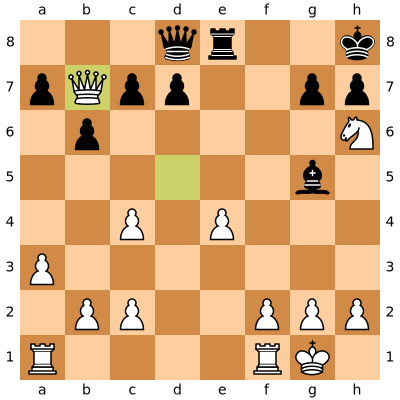

In [8]:
import math


def find_best_move_shallow(board, white=True):
    
    best_value = -math.inf
    best_move = None

    for move in board.legal_moves:

        board.push(move)
        
        if white:
            current_value = evaluate_board(board)
        else:
            current_value = -evaluate_board(board)
            
        if current_value > best_value:
            best_value = current_value
            best_move = move
        board.pop()
    
    return best_move

board_copy = board.copy()

best_move = find_best_move_shallow(board_copy)

board_copy.push(best_move)
board_copy

Not a really good move because our horse will be captured by enemy's bishop and
our agent can not see this since it only looks one step ahead.


<center> <h2> Minimax algorithm </h2> </center>

To be able to look more than one step ahead we have to model our opponents move.
Minimax assumes that our opponent makes best moves and, therefore, the opponent tries to minimize
our possible gains while we try to maximize ours (see lecture slides).

Below we provide you with our partial implementation of minimax. It has a parameter ```depth```
which specifies the depth of our game tree. Uncomment the correct lines and fill in missing parts with your code and run the code cell.

# of Nodes evaluated:  55002
Best value found:  9000


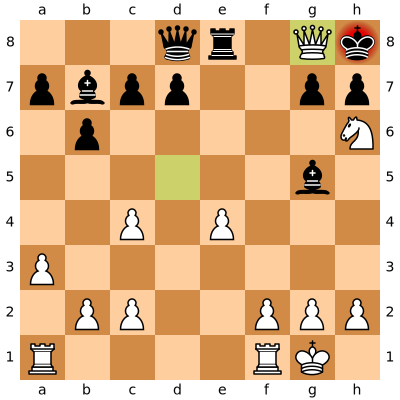

In [12]:
# Global variable used to count the number
# of nodes we explored. Will be used to compare
# naive minimax with its alpha beta pruning version.
move_count = 0


def minimax(board,
            depth,
            white=True,
            is_max_branch=True,
            ):
    
    global move_count
    move_count = move_count + 1
    
    
    # Check if we reached the depth limit or
    # if the node is terminal (does not have any possible legal moves)
    if depth == 0 or (len(list(board.legal_moves)) == 0):
        
                    
        if white:
            
            return evaluate_board(board)
        else:
            
            return -evaluate_board(board)
    

    # Max branch
    if is_max_branch:
        
        #best_move_value = math.inf
        # Or
        best_move_value = -math.inf

        for move in board.legal_moves:

            board.push(move)
#             best_move_value = max(..., minimax(...,
#                                                depth=...,
#                                                white=...,
#                                                is_max_branch=...
#                                                 ))
            best_move_value = max(best_move_value, minimax(board, depth = depth-1, white = not white, is_max_branch = not is_max_branch))

            board.pop()
        
        return best_move_value
    
    # Min branch
    
    best_move_value = math.inf
    # OR
    #best_move_value = -math.inf

    for move in board.legal_moves:

        board.push(move)

#         best_move_value = min(..., minimax(...,
#                                            depth=...,
#                                            white=...,
#                                            is_max_branch=...))
        best_move_value = min(best_move_value, minimax(board, depth = depth-1, white = not white, is_max_branch = not is_max_branch))

        board.pop()
    
    return best_move_value



def find_best_move_minimax(board,
                           white=True):
    
    global move_count
    move_count = 0
    
    best_value = -math.inf
    best_move = None
    

    for move in board.legal_moves:

        board.push(move)
        current_value = minimax(board,
                                depth=2,
                                white=white,
                                is_max_branch=False)
        
        if current_value > best_value:
            best_value = current_value
            best_move = move
        board.pop()
        
    print("# of Nodes evaluated: ", move_count)
    print("Best value found: ", best_value)
    
    return best_move

board_copy = board.copy()

move = find_best_move_minimax(board_copy)

board_copy.push(move)

board_copy

We can see that based on the output of our algorithm found a solution to our puzzle (since it found a path to the solution that gives us 9000 which is checkmate). We have also showed the first step towards the best
solution. We will see the whole solution in the next cell.

Now let us see the whole solution. We will define some functions to present the whole game animation:

In [14]:
import time
from IPython.display import display, HTML, clear_output

import random


def who(player):
    return "White" if player == chess.WHITE else "Black"

def display_board(board, use_svg):
    if use_svg:
        return board._repr_svg_()
    else:
        return "<pre>" + str(board) + "</pre>"

def play_game(player1, player2, board, visual="svg", pause=0.1):
    """
    playerN1, player2: functions that takes board, return uci move
    visual: "simple" | "svg" | None
    """
    use_svg = (visual == "svg")
    global move_count
    try:
        while not board.is_game_over(claim_draw=True):
            if board.turn == chess.WHITE:
                uci = player1(board)
            else:
                uci = player2(board)
            name = who(board.turn)
            board.push_uci(uci)
            board_stop = display_board(board, use_svg)
            html = "<b>Move %s %s, Play '%s':</b><br/>%s, moves searched %s" % (
                       len(board.move_stack), name, uci, board_stop, move_count)
            if visual is not None:
                if visual == "svg":
                    clear_output(wait=True)
                display(HTML(html))
                if visual == "svg":
                    time.sleep(pause)
    except KeyboardInterrupt:
        msg = "Game interrupted!"
        return (None, msg, board)
    result = None
    if board.is_checkmate():
        msg = "checkmate: " + who(not board.turn) + " wins!"
        result = not board.turn
    elif board.is_stalemate():
        msg = "draw: stalemate"
    elif board.is_fivefold_repetition():
        msg = "draw: 5-fold repetition"
    elif board.is_insufficient_material():
        msg = "draw: insufficient material"
    elif board.can_claim_draw():
        msg = "draw: claim"
    if visual is not None:
        print(msg)
    return (result, msg, board)

def player_white(board):
    
    return find_best_move_minimax(board).uci()

def player_black(board):
    
    return find_best_move_minimax(board, False).uci()

play_game(player_white, player_black, board.copy(), pause=1.0)

checkmate: White wins!


(True,
 'checkmate: White wins!',
 Board('3q2rk/pbpp1Npp/1p6/6b1/2P1P3/P7/1PP2PPP/R4RK1 b - - 1 2'))

As you can see the solution was successfully found. And moreover, there is no way black
can avoid the checkmate if white make the right moves. Here we solved a puzzle that had a solution
in two moves but there are puzzles that require to find solution in greater number of steps, so the 
depth of our game tree should be bigger. Moreover, during a real game bigger depth of a game tree means better
results. But naive minimax is too expensive. Therefore, we implement minimax with alpha beta prunning next.

<center> <h2> Minimax algorithm with alpha beta pruning </h2> </center>

If you remember from the lecture slides alpha beta prunning allows to prune some nodes
of the game tree that are known to be not optimal. During the tree traversal we collect the information
on upper and lower bound for each node and this allows to avoid exploring some branches of the game tree.
Below we implement the alpha beta prunning type of minimax algorithm. The complexity of this algorithm is $O(b^m)$ in the worst case (same as naive minimax) and $O(b^\frac{m}{2})$ in the best case. Therefore, we can have a twice deeper game tree while spending the same amount of computation. Again, you are required to uncomment the right parts and run the code. 

# of Nodes evaluated:  11605
Best value found:  9000


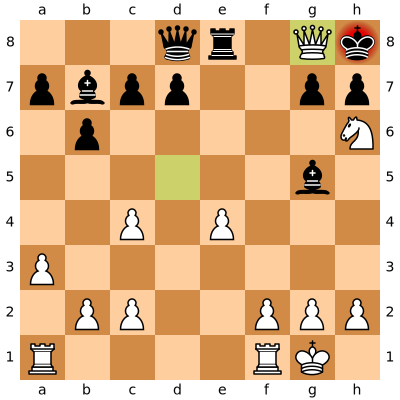

In [16]:
move_count = 0


def minimax_alpha_beta_prunning(board,
                                depth,
                                alpha=-math.inf,
                                beta=math.inf,
                                is_max_branch=True,
                                white=True):
    
    global move_count
    
    move_count = move_count + 1
    
    if depth == 0 or (len(list(board.legal_moves)) == 0) or (board.can_claim_draw()):
        
                    
        if white:
            
            return evaluate_board(board)
        else:
            
            return -evaluate_board(board)
    
    
    # Max branch
    if is_max_branch:
        
        best_move_value = -math.inf
        # OR
        #best_move_value = math.inf

        for move in board.legal_moves:

            board.push(move)

            best_move_value = max(best_move_value, minimax_alpha_beta_prunning(board,alpha=alpha,beta=beta,depth=depth-1,is_max_branch=False,white=white))

            alpha = max(alpha, best_move_value)
# OR
#             best_move_value = min(best_move_value, minimax_alpha_beta_prunning(board,
#                                                                                alpha=alpha,
#                                                                                beta=beta,
#                                                                                depth=depth-1,
#                                                                                is_max_branch=False,
#                                                                                white=white) 
#                                  )
#             alpha = min(alpha, best_move_value)


            
            if best_move_value >= beta:
                board.pop()
                break

            board.pop()
        
        return best_move_value
    
    # Min branch
    
    best_move_value = math.inf
    # OR
    #best_move_value = -math.inf

    for move in board.legal_moves:

        board.push(move)

        best_move_value = min(best_move_value, minimax_alpha_beta_prunning(board,alpha=alpha,beta=beta,depth=depth-1,is_max_branch=True,white=white))
        beta = min(beta, best_move_value)
# OR
#         best_move_value = max(best_move_value, minimax_alpha_beta_prunning(board,
#                                                                            alpha=alpha,
#                                                                            beta=beta,
#                                                                            depth=depth-1,
#                                                                            is_max_branch=True,
#                                                                            white=white) 
#                              )
#         beta = max(beta, best_move_value)


        
        if best_move_value <= alpha:
            board.pop()
            break

        board.pop()
    
    return best_move_value


def find_best_move_minimax_alpha_beta_prunning(board, white=True):
    
    global move_count
    move_count = 0
    
    best_value = -math.inf
    best_move = None
    

    for move in board.legal_moves:

        board.push(move)
        current_value = minimax_alpha_beta_prunning(board,
                                depth=2,
                                white=white,
                                is_max_branch=False)
        
        if current_value > best_value:
            best_value = current_value
            best_move = move
        board.pop()
        
    print("# of Nodes evaluated: ", move_count)
    print("Best value found: ", best_value)
    
    return best_move

board_copy = board.copy()

move = find_best_move_minimax_alpha_beta_prunning(board_copy)

board_copy.push(move)

board_copy

As we can see the same solution was found but just more efficiently (pay attention to the number
of evaluated nodes).

Again, let us see the whole game:

In [18]:
def player_white(board):
    
    return find_best_move_minimax_alpha_beta_prunning(board).uci()

def player_black(board):
    
    return find_best_move_minimax_alpha_beta_prunning(board, False).uci()

play_game(player_white, player_black, board.copy(), pause=1.0)

checkmate: White wins!


(True,
 'checkmate: White wins!',
 Board('3q2rk/pbpp1Npp/1p6/6b1/2P1P3/P7/1PP2PPP/R4RK1 b - - 1 2'))

Now, you are requried to solve two other chess puzzles and display the final solution in the notebook,
so that we can grade it. 

In [20]:
# Solve this
board_2 = chess.Board(fen='r1bq2k1/ppp2r1p/2np1pNQ/2bNpp2/2B1P3/3P4/PPP2PPP/R3K2R w KQ - 0 1')
play_game(player_white, player_black, board_2.copy(), pause=1.0)

checkmate: White wins!


(True,
 'checkmate: White wins!',
 Board('r1b2Qk1/ppp2r1p/2np1qN1/2b1pp2/2B1P3/3P4/PPP2PPP/R3K2R b KQ - 1 2'))

In [21]:
# Solve this
board_3 = chess.Board(fen='r1bk3r/1pp2ppp/pb1p1n2/n2P4/B3P1q1/2Q2N2/PB3PPP/RN3RK1 w - - 0 1')
play_game(player_white, player_black, board_3.copy(), pause=1.0)

checkmate: White wins!


(True,
 'checkmate: White wins!',
 Board('r1bk3r/1pp2p1p/pb1p1B2/n2P4/B3P1q1/5N2/P4PPP/RN3RK1 b - - 0 2'))

<center> <h2> Full Game </h2> </center>

Now you can play against your agent or you can make two agents play against each other.
Try changing the depth of the game tree and see how it changes the agent's behaviour.
This is an optional part and it will not be graded.

In [22]:
def human_player(board):
    display(board)
    uci = get_move("%s's move [q to quit]> " % who(board.turn))
    legal_uci_moves = [move.uci() for move in board.legal_moves]
    while uci not in legal_uci_moves:
        print("Legal moves: " + (",".join(sorted(legal_uci_moves))))
        uci = get_move("%s's move[q to quit]> " % who(board.turn))
    return uci


def get_move(prompt):
    uci = input(prompt)
    if uci and uci[0] == "q":
        raise KeyboardInterrupt()
    try:
        chess.Move.from_uci(uci)
    except:
        uci = None
    return uci

play_game(player_white, human_player, chess.Board(), pause=1.0)

checkmate: White wins!


(True,
 'checkmate: White wins!',
 Board('rn3bnr/p1p4p/3p2p1/4p3/2k1Np2/1Q2P3/PPPP2PP/RNB1K2R b Q - 4 17'))

<center> <h2> Self Play </h2> </center>


In [23]:
play_game(player_white, player_black, chess.Board(), pause=2.0)

checkmate: Black wins!


(False,
 'checkmate: Black wins!',
 Board('r1b4k/2p3r1/2n5/4p3/pp1p1p1p/6bK/PPPPP1P1/1RB2B2 w - - 0 82'))

<center> <h2> Question # 2 (optional) </h2> </center>

The objective of this question is to report on the pairing of search depth and evaluation sophistication. For instance, can we get away with a crude evaluation if we’re allowed to look further ahead? The two depth candidates are 2 and 3, referred to as depth 1, depth 2 respectively. Use three evaluations functions with different complexity levels. A couple of ideas for the evaluation techniques include: counting pieces (eval 1) and weighing piece values as a function of how far they are from the center of the board (eval 2). You can also use an advnced evaluation function which was already a part of the previous questions.

Two depth options and three evaluation options result in 6 possible chess agents. Play each of these agents against the others to produce a bar graph of the overall win rates. The bar graph should have 6 ticks on the x-axis with win rates on the y-axis.

It might also help to read the documentation of the ```python-chess``` library that we are using:
https://github.com/niklasf/python-chess. You can reuse the previous code that we provided while working on the question.